# Hate Speech Recognition
This notebook has a collection of various data processing, visualization and predictive techniques and that I use. The problem it tackles is hate speech recognition by tweet classification (thus data contain swearing).

---
Each cell performs a certain independant operation on the data. That way the data are beeing looped several times, which is not ideal from a performance point of view. But it makes the notebook more readable and modular.  


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics, svm, model_selection, preprocessing
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack, coo_matrix
from sklearn.model_selection import cross_val_score
from google.colab import drive
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import re
from matplotlib.pyplot import figure
from wordcloud import WordCloud

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)	

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# Load data
drive.mount('/content/drive')
file = '/content/drive/My Drive/Colab Notebooks/Hate_Speech_Tweet_Classification/hate_tweets.csv'
rawData = pd.read_csv(file)
data = rawData[['tweet','class']]

pd.set_option('max_colwidth', 200)
print("---------------------------------------------------")
print("Raw data form: ")
print(rawData.head())

print("---------------------------------------------------")
print("Hate speech samples: ")
print(data.loc[data["class"] == 0].sample(5))

print("---------------------------------------------------")
print("Offensive speech samples: ")
print(data.loc[data["class"] == 1].sample(5))

print("---------------------------------------------------")
print("Normal speech samples: ")
print(data.loc[data["class"] == 2].sample(5))




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
---------------------------------------------------
Raw data form: 
   Unnamed: 0  ...                                                                                                                                         tweet
0           0  ...  !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
1           1  ...                                                        

Class count: 
1    19190
2     4163
0     1430
Name: class, dtype: int64


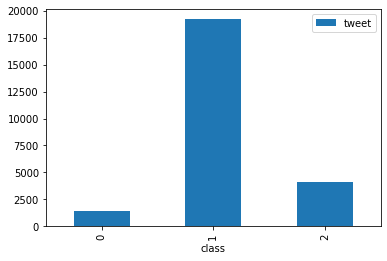

Class count after sampling: 
2    9595
1    9595
0    9595
Name: 0, dtype: int64


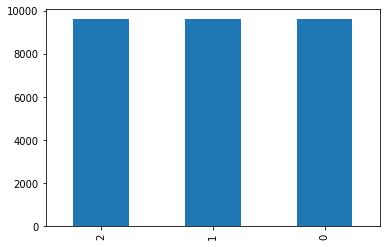

Datafrrame dimensions:  (24783,)
Resampled array dimensions:  (28785, 1)
Squeezed array dimensions:  (28785,)


In [0]:
# Check for unbalanced data set

print("Class count: ")
print(data["class"].value_counts())
data.groupby('class').count().plot(kind='bar')
plt.show()
''' Alternate way
data['class'].value_counts().plot(kind='bar')
plt.show()
'''

largeColumnSize = len(data[data['class']== 1])

# Applying over-sampling on the classes with the least examples, so they reach half the number of examples of the numerous class 
randomOverSampler = RandomOverSampler(sampling_strategy={0: largeColumnSize//2, 1: largeColumnSize, 2: largeColumnSize//2}, random_state=0)
X_over_sampled, y_over_sampled = randomOverSampler.fit_resample(data['tweet'].to_numpy().reshape(-1, 1), data['class'])

# Applying under-sampling so that the class / classes with the most examples reach the number of examples of the smallest class
randomUnderSampler = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = randomUnderSampler.fit_resample(X_over_sampled, y_over_sampled)

X_resampledDF = pd.DataFrame(X_resampled)
y_resampledDF = pd.DataFrame(y_resampled)

print("Class count after sampling: ")
print(y_resampledDF[0].value_counts())
y_resampledDF[0].value_counts().plot(kind='bar')
plt.show()

# Our original data was list of tweets (strings). But .reshape(-1, 1) added un extra dimension that we dont need anymore.
print("Datafrrame dimensions: ",data['tweet'].to_numpy().shape)
print("Resampled array dimensions: ",X_resampled.shape)
X_resampled_squeezed = np.squeeze(X_resampled, axis=1)
print("Squeezed array dimensions: ",X_resampled_squeezed.shape)


tweets = X_resampled_squeezed.tolist()

**Tag Removal**

---
Although tag removal seems an intresting idea, it seems to reduce the performance of our predictive models, as it carrys the information of who wrote the tweet. 

---

Having a different dataset or having the intension not to use profiling data we would rather remove the tags. For this project we would keep the tags, in order to further boost the performance of our predictive models.


In [0]:
# Tag Removal
removedTagTweets = []
def remove_tags(tweets):
  for tweet in tweets:
    removedTagTweets.append(re.sub('@\S*', '', tweet))
  return removedTagTweets

tweets = remove_tags(tweets)


In [0]:
# URL Removal
removedUrlTweets = []
def remove_urls(tweets):
  for tweet in tweets:
    removedUrlTweets.append(re.sub('http\S+', '', tweet))
  return removedUrlTweets

tweets = remove_urls(tweets)

In [0]:
# Lower Case Conversion
lowerTweets = []
def convert_to_lower(tweets):
  for tweet in tweets:
    lowerTweets.append(tweet.lower())
  return lowerTweets

tweets = convert_to_lower(tweets)

In [0]:
# Stop word removal
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download the set of stop words the first time
import nltk
nltk.download('stopwords')
nltk.download('punkt')

noStopWordTweets = []
def remove_stopwords(tweets):

  stop_words = set(stopwords.words('english')) # Set improves performance
  
  for tweet in tweets:  
    word_tokens = word_tokenize(tweet) 
    filtered_tweet = [word for word in word_tokens if not word in stop_words] 
    filteredTweetString = ' '.join(word for word in filtered_tweet)
    noStopWordTweets.append(filteredTweetString)
    #print(tweet)
    #print(filtered_tweet)    
    #print (filteredTweetString)
  return noStopWordTweets

tweets = remove_stopwords(tweets)

print(tweets)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
["`` @ blackman38tide : @ whalelookyhere @ howdydowdy11 queer '' gaywad", "`` @ cb_baby24 : @ white_thunduh alsarabsss '' hes beaner smh tell hes mexican", "`` @ devilgrimz : @ vigxrarts 're fucking gay , blacklisted hoe '' holding # tehgodclan anyway", "`` @ markroundtreejr : lmfaoooo hate black people 's black people niggers", "`` @ nochillpaz : `` least 'm nigger '' lmfao", "`` @ notoriousbm95 : @ _whiteponyjr_ ariza snake coward '' least n't cripple like hero roach lmaoo", "`` @ rtnba : drakes new shoes released nike/jordan ... . yes , 's glitter shoes ... .dudes fag", '`` @ theomaxximus : # gerryshalloweenparty halloween yesterday stupid nigger', "`` @ ashlingwilde : @ itsnotadam bored supposed cute , faggot ? '' sometimes", "`` @ bigbootybishopp : @ whit

**Character Removal**

---
Following are different approaches to character removal from the data with python. Just one of the following cells need to be excecuted.


In [0]:
# Character removal
unwatedChars = '''()-[]{};:'"\,<>./@#$%^&*_~1234567890'''
def remove_unwanted_characters(tweets):
  cleanTweets = []
  for tweet in tweets:
    for punc in list(unwatedChars):
      tweet = tweet.replace(punc,'')
    cleanTweets.append(tweet)
  return cleanTweets

tweets = remove_unwanted_characters(tweets)

In [0]:
# An alternate way for char removal
unwatedChars = '''()-[]{};:'"\,<>./@#$%^&*_~1234567890''' 
'''
def remove_unwanted_characters(tweet):  
  cleanString = ""
  for char in tweet:
    if not (char in unwatedChars):
      cleanString = cleanString+char
  return cleanString

cleanTweets = []
for tweet in removedTagTweets:
  cleanTweets.append(remove_unwanted_characters(tweet))
tweets =  cleanTweets
'''

In [0]:
# An alternate way for char removal
'''
X_resampled_squeezedDF = pd.DataFrame(X_resampled_squeezed)
def remove_unwanted_characters(tweet):
  return ''.join(i for i in tweet if not i in list(unwatedChars)) 
tweets = X_resampled_squeezedDF.apply(lambda tweet: remove_unwanted_characters(tweet) , axis=1) 
'''


In [0]:
# TODO the char removal with the use of lambdas and filter
'''
tweets = list(map(lambda tweet:tweet.replace(punctuations,''), removedTagTweets))
'''

In [0]:
# Lemmatization
import spacy
nlp = spacy.load('en')

def lemmatize(tweets):
  lemmatizedTweets = []
  for tweet in tweets:
    lemmatizedTweet = []
    for token in nlp(tweet):
      lemmatizedTweet.append(token.lemma_)
    lemmatizedTweetString = ' '.join(word for word in lemmatizedTweet)
    lemmatizedTweets.append(lemmatizedTweetString)
  return lemmatizedTweets

tweets = lemmatize(tweets)

In [0]:
# Convert our data from lists to a dataframe
cleanData = zip(y_resampled, tweets)
cleanDataDf = pd.DataFrame(cleanData, columns = ['class','tweet']) 
cleanDataDf

,class,tweet
0,0,` ` blackmantide whalelookyhere howdydowdy queer gaywad
1,0,` ` cbbaby whitethunduh alsarabsss -PRON- s bean smh tell -PRON- s mexican
2,0,` ` devilgrimz vigxrart re fuck gay blacklist hoe hold tehgodclan anyway
3,0,` ` markroundtreejr lmfaoooo hate black people s black people nigger
4,0,` ` nochillpaz ` ` least m nigger lmfao
...,...,...
28780,2,munch ww cracker amp study nycs tran syst since nyc amp nt thing yrs clubinsomnia vacay
28781,2,ariennajanee mutual lil yellow bone
28782,2,teabagger state like mississippi opposed minimum wage child labor law union proscab sweatshop work pretty much slavery
28783,2,firecashman ? ? root royal october yankee


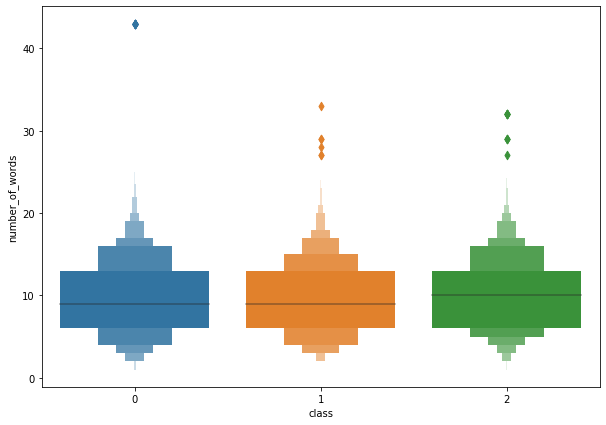

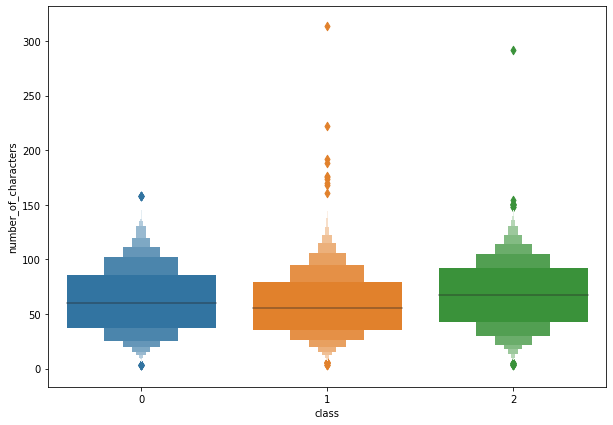

In [0]:
# Create and plot potential features word count and character count of a tweet, in order to see which one shows more variation per class, thus carring more information

tweetWordCount = []
for tweet in tweets:
  tweetWordCount.append(len(tweet.split()))

wordCountData = zip(y_resampled, tweetWordCount)
wordCountDataDf = pd.DataFrame(wordCountData, columns = ['class', 'number_of_words']) 

figure(figsize=(10, 7))
ax = sns.boxenplot(x="class", y="number_of_words",  data=wordCountDataDf)
plt.show()

tweetCharCount = []
for tweet in tweets:
  tweetCharCount.append(len(tweet))

charCountData = zip(y_resampled, tweetCharCount)
charCountDataDf = pd.DataFrame(charCountData, columns = ['class', 'number_of_characters']) 

figure(figsize=(10, 7))
ax = sns.boxenplot(x="class", y="number_of_characters",  data = charCountDataDf)
plt.show()

# Add the char count feature to our data as it show a little bit more variation between the classes
cleanDataDf['number_of_characters'] = tweetCharCount 


Hate speech word cloud


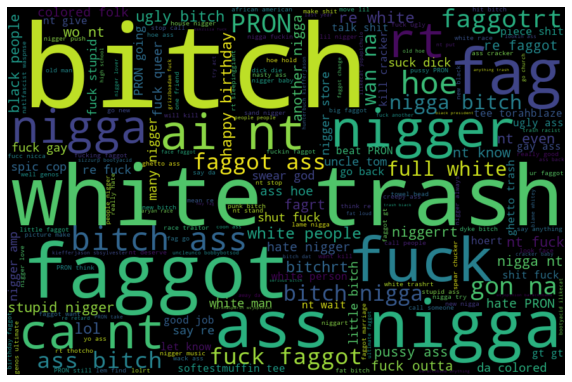

Offensive speech word cloud


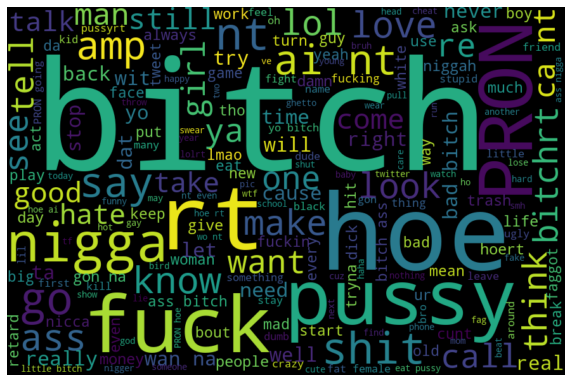

Normal speech word cloud


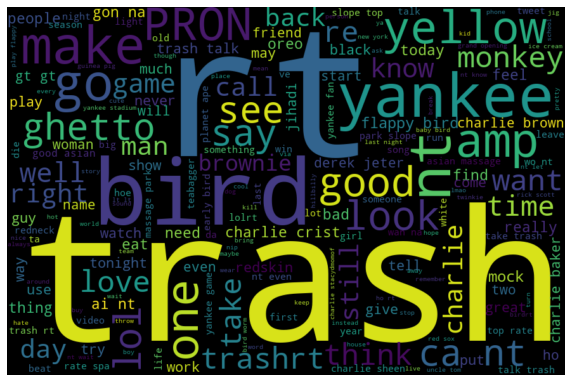

In [0]:
# Visualizing most common words of each class

print("Hate speech word cloud")
# Create a string of all hate tweets
hateText = ""
for tweet in cleanDataDf[cleanDataDf["class"] == 0]["tweet"]: 
  hateText = hateText + tweet 
  
# Create the wordcloud object
hateWordcloud = WordCloud(width=880, height=580, margin=0).generate(hateText)
 
# Display the generated image:
figure(figsize=(10, 10))
plt.imshow(hateWordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Offensive speech word cloud")
# Create a string of all hate tweets
offensiveText = ""
for tweet in cleanDataDf[cleanDataDf["class"] == 1]["tweet"]: 
  offensiveText = offensiveText + tweet 
  
# Create the wordcloud object
offensiveWordcloud = WordCloud(width=880, height=580, margin=0).generate(offensiveText)
 
# Display the generated image:
figure(figsize=(10, 10))
plt.imshow(offensiveWordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("Normal speech word cloud")
# Create a string of all hate tweets
normalText = ""
for tweet in cleanDataDf[cleanDataDf["class"] == 2]["tweet"]: 
  normalText = normalText + tweet 
  
# Create the wordcloud object
normalWordcloud = WordCloud(width=880, height=580, margin=0).generate(normalText)
 
# Display the generated image:
figure(figsize=(10, 10))
plt.imshow(normalWordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
# Train / test split with stratify, to ensure same percentage of each class is present in the train and the test set.   
print(tweets[0:20]) 

X_train, X_test, y_train, y_test = model_selection.train_test_split(tweets, y_resampled, test_size=0.30, random_state=10, stratify = y_resampled)

# --- Tf/idf vectorization of strings
tfidfVec_train = TfidfVectorizer()
X_train_tfidf = tfidfVec_train.fit_transform(X_train)
X_test_tfidf = tfidfVec_train.transform(X_test)
#print(X_train_tfidf[0])

['` `   blackmantide    whalelookyhere   howdydowdy queer   gaywad', '` `   cbbaby    whitethunduh alsarabsss   -PRON- s bean smh tell -PRON- s mexican', '` `   devilgrimz    vigxrart re fuck gay   blacklist hoe   hold   tehgodclan anyway', '` `   markroundtreejr   lmfaoooo hate black people s black people nigger', '` `   nochillpaz   ` ` least m nigger   lmfao', '` `   notoriousbm    whiteponyjr ariza snake coward   least nt cripple like hero roach lmaoo', '` `   rtnba   drake new shoe release nikejordan    yes   s glitter shoe   dude fag', '` `   theomaxximus    gerryshalloweenparty halloween yesterday stupid nigger', '` `   ashlingwilde    itsnotadam bore suppose cute   faggot ?   sometimes', '` `   bigbootybishopp    whitethunduh lassen cc   coach want   feel -PRON- will get nig doubt', '` `   jayswaggkillah   jackie retard   blondeproblem   least make grill cheese !', '` `   jgabsss   stacey dash      badd bitch evaaaa', '` ` nt worry nigga see   worry nigga nt see   dat s da nigg

**Dimensionality Reduction** 

---
Tf/idf data are in sparse format and therefore need to be transformed into dense to use PCA. This needs too much time and memory. 

---
Alternativly we rather use SVD to reduce the dimensions.

---
As with the current dataset we try to achive the best predictive performance, it is better not to use any dimensionality reduction technique.


In [0]:
# SVD dimensionality reduction
from sklearn.decomposition import TruncatedSVD

def performSVD(tweets):
  svd = TruncatedSVD(n_components = 1000)
  principalComponentsTrain = svd.fit_transform(X_train_tfidf)
  principalComponentsTest = svd.transform(X_test_tfidf)

  print('Original feature #:', X_train_tfidf.shape[1])
  print('Reduced feature #:', principalComponentsTrain.shape[1])

  return principalComponentsTrain, principalComponentsTest;

X_train_tfidf, X_test_tfidf = performSVD(tweets)


KeyboardInterrupt: ignored

In [0]:
# PCA dimensionality reduction
from sklearn.decomposition import PCA

def performPCA(tweets):
  pca = PCA(n_components = 0.9)
  principalComponentsTrain = pca.fit_transform(X_train_tfidf.todense())
  principalComponentsTest = pca.transform(X_test_tfidf.todense())

  print('Original feature #:', X_train_tfidf.shape[1])
  print('Reduced feature #:', principalComponentsTrain.shape[1])

  return principalComponentsTrain, principalComponentsTest;

X_train_tfidf, X_test_tfidf = performPCA(tweets)

KeyboardInterrupt: ignored

--- Metrics of SVM classifier with kernel='linear'and C = 100 :
recall:  0.9412978552847644
prec:  0.9433809476642488
f1:  0.9406205471256789
acc:  0.9412922649374711


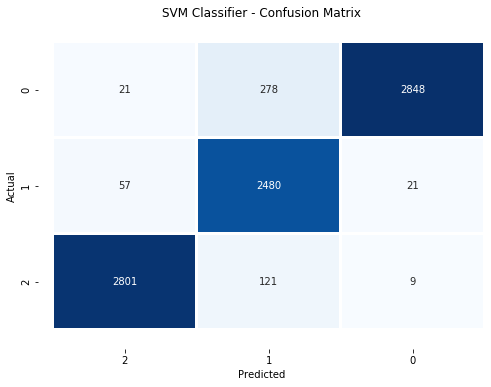

In [0]:
# SVM classifier
modelSVM = svm.SVC(kernel='linear', C = 10)
modelSVM.fit(X_train_tfidf, y_train)

y_pred = modelSVM.predict(X_test_tfidf)

print("--- Metrics of SVM classifier with kernel='linear'and C = 100 :")
print("recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("prec: ", metrics.precision_score(y_test, y_pred, average='macro'))
print("f1: ", metrics.f1_score(y_test, y_pred, average='macro'))
print("acc: ", metrics.accuracy_score(y_test, y_pred))

confusionMatrix = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
hm = sns.heatmap(confusionMatrix.T, cmap="Blues", linewidths=2, square=False, annot=True, cbar=False, fmt='d',
                 xticklabels=cleanDataDf["class"] .unique(), yticklabels=cleanDataDf["class"].unique())
# Adding margin to figure
bottomMarg, topMarg = hm.get_ylim()
hm.set_ylim(bottomMarg + 0.2, topMarg - 0.2)
leftMargm, rightMarg = hm.get_xlim()
hm.set_xlim(rightMarg + 0.1, leftMargm)

plt.title('SVM Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [0]:
# MultinomialNB classifier
modelNaiveBayes = MultinomialNB()
modelNaiveBayes.fit(X_train_tfidf, y_train)

y_pred = modelNaiveBayes.predict(X_test_tfidf)

print("--- Metrics of Multinomial Naive Bayes classifier: ")
print("recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("prec: ", metrics.precision_score(y_test, y_pred, average='macro'))
print("f1: ", metrics.f1_score(y_test, y_pred, average='macro'))
print("acc: ", metrics.accuracy_score(y_test, y_pred))

--- Metrics of Multinomial Naive Bayes classifier: 
recall:  0.8747149628483174
prec:  0.8782440597365349
f1:  0.8752166463304327
acc:  0.8747105141269106


In [0]:
# Logistic Regression classifier
modelLogisticRegression = LogisticRegression()
modelLogisticRegression.fit(X_train_tfidf, y_train)

y_pred = modelLogisticRegression.predict(X_test_tfidf)

print("--- Metrics of Logistic Regression classifier: ")
print("recall: ", metrics.recall_score(y_test, y_pred, average='macro'))
print("prec: ", metrics.precision_score(y_test, y_pred, average='macro'))
print("f1: ", metrics.f1_score(y_test, y_pred, average='macro'))
print("acc: ", metrics.accuracy_score(y_test, y_pred))

--- Metrics of Logistic Regression classifier: 
recall:  0.9131557644708276
prec:  0.913402546688261
f1:  0.9124925340546262
acc:  0.9131542380731821


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
# Cross-Validation Greed Search
from sklearn import svm
from sklearn.model_selection import GridSearchCV

tfidfVec_dataset = TfidfVectorizer()
dataset_tfidf = tfidfVec_dataset.fit_transform(tweets)

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(dataset_tfidf, y_resampled)

print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
  print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
  print()
print("Best parameters: ",clf.best_params_)

['mean_fit_time', 'mean_score_time', 'mean_test_score', 'param_C', 'param_kernel', 'params', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'std_fit_time', 'std_score_time', 'std_test_score']
{'C': 10, 'kernel': 'rbf'}
Grid scores on development set:

0.944 (+/-0.004) for {'C': 1, 'kernel': 'linear'}

0.965 (+/-0.002) for {'C': 1, 'kernel': 'rbf'}

0.951 (+/-0.007) for {'C': 10, 'kernel': 'linear'}

0.971 (+/-0.003) for {'C': 10, 'kernel': 'rbf'}



In [0]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding, Flatten, SpatialDropout1D,LSTM,Conv1D,GlobalMaxPooling1D
from keras.utils.np_utils import to_categorical 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

y_train_OnHotEn = pd.get_dummies(y_train)
y_test_OnHotEn = pd.get_dummies(y_test)

modelDeepNN = Sequential()
modelDeepNN.add(Dense(100, input_dim=X_train_tfidf.shape[1], activation="relu"))
modelDeepNN.add(Dropout(0.6))
modelDeepNN.add(Dense(100, activation="relu"))
modelDeepNN.add(Dropout(0.6))
modelDeepNN.add(Dense(3, activation="softmax"))
modelDeepNN.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
modelDeepNN.summary()

history =  modelDeepNN.fit(X_train_tfidf,y_train_OnHotEn ,epochs = 25,validation_data=(X_test_tfidf,y_test_OnHotEn), verbose = 2)

loss, accuracy = modelDeepNN.evaluate(X_train_tfidf,y_train_OnHotEn, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = modelDeepNN.evaluate(X_test_tfidf,y_test_OnHotEn, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 500)               9552500   
_________________________________________________________________
dropout_7 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_8 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 1503      
Total params: 9,804,503
Trainable params: 9,804,503
Non-trainable params: 0
_________________________________________________________________
Train on 20149 samples, validate on 8636 samples
Epoch 1/25
 - 7s - loss: 0.4244 - acc: 0.8353 - val_loss: 0.2

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# save model
# serialize model to JSON
modelDeepNN_json = modelDeepNN.to_json()

with open("model.json", "w") as json_file:
    json_file.write(modelDeepNN_json)
    
# serialize weights to HDF5
modelDeepNN.save_weights("model.h5")
print("Saved model to disk")